# Задание №2 - Анализ данных о сердечно-сосудистых заболеваниях

## Часть 1. Предварительный анализ данных 

In [199]:
import numpy as np
import pandas as pd
%matplotlib inline
df = pd.read_csv('mlbootcamp5_train.csv', sep = ";")

import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

# Настройка параметров визуализации seaborn
sns.set_context(
    "notebook", 
    font_scale = 1,       
    rc = { "figure.figsize": (11, 8), "axes.titlesize": 10 }
)

# Импорт rcParams из matplotlib и настройка параметров визуализации matplotlib
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 9


In [201]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


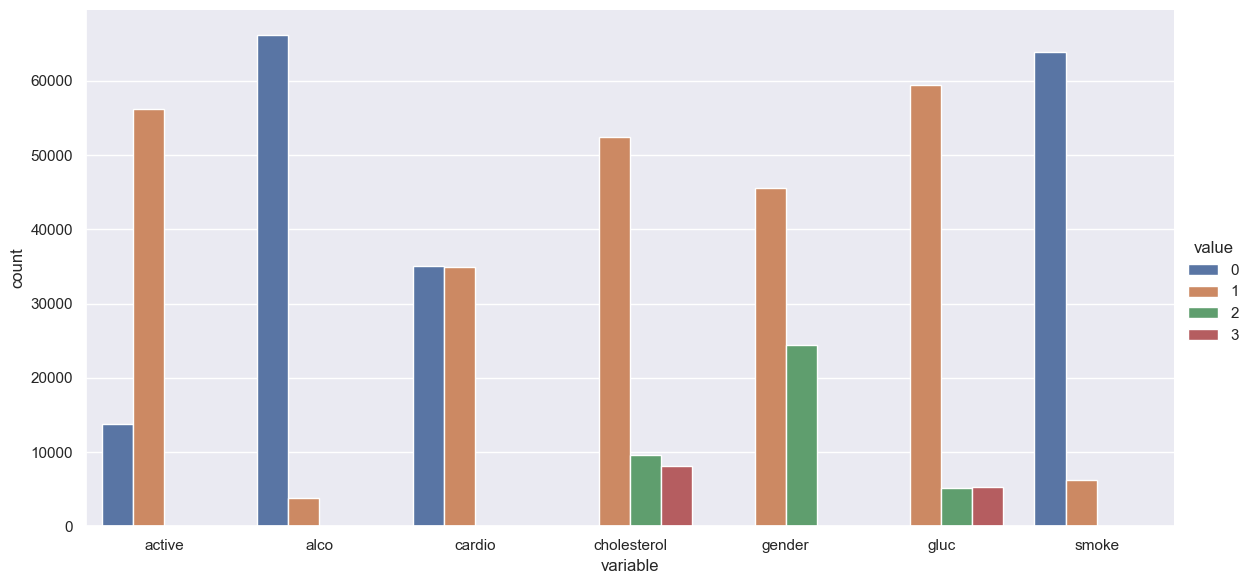

In [203]:
# Преобразование DataFrame в длинный формат
df_uniques = pd.melt(df, value_vars=['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'])

# Группировка и подсчет количества уникальных значений
df_uniques = df_uniques.groupby(['variable', 'value']).size().reset_index(name='count')

# Преобразование значения в строковый формат
df_uniques['value'] = df_uniques['value'].astype(str)

# Построение графика
sns.catplot(x='variable', y='count', hue='value', data=df_uniques, kind='bar', height=6, aspect=2)

# Показать график
plt.show()

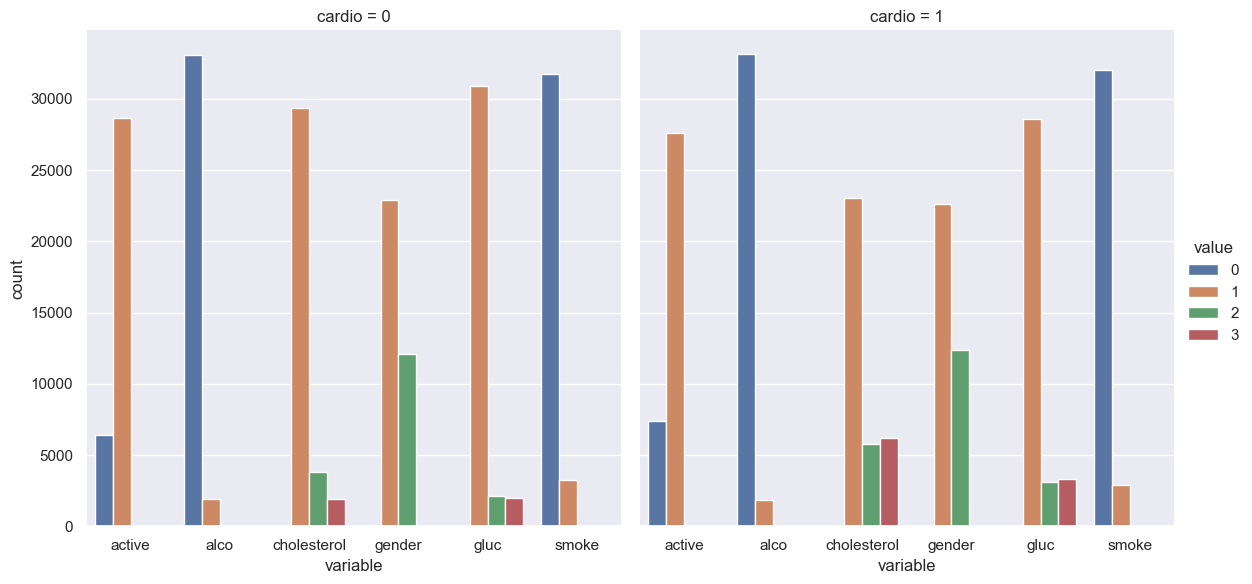

In [205]:
# Преобразуем данные в длинный формат, чтобы легче было анализировать распределение значений для каждой переменной
df_uniques = pd.melt(frame=df, value_vars=['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'], id_vars=['cardio'])

# Группируем данные и подсчитываем количество значений для каждой комбинации переменных и значения целевого признака
df_uniques = df_uniques.groupby(['variable', 'value', 'cardio']).size().reset_index(name='count')

# Преобразуем значение в строковый формат для избежания ошибки
df_uniques['value'] = df_uniques['value'].astype(str)

# Строим столбчатый график, показывающий распределение значений для каждой переменной с разделением на подграфики по значению целевого признака
sns.catplot(x='variable', y='count', hue='value', col='cardio', data=df_uniques, kind='bar', height=6)

In [206]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


## 1.1. Основные наблюдения 

### Вопрос 1.1 Сколько мужчин и женщин присутствует в этом наборе данных? Значения признака gender не были указаны (обозначает ли «1» женщин или мужчин) — выясните это, проанализировав рост, предположив, что мужчины в среднем выше.
#### Решение:



In [211]:
 one_mean = df[df['gender'] == 1]['height'].mean()
 two_mean = df[df['gender'] == 2]['height'].mean()
print (one_mean , two_mean)


161.35561168460356 169.94789538210054


#### Следовательно, женщины - 1, а мужчины - 2.

In [214]:
df['gender'].value_counts()

gender
1    45530
2    24470
Name: count, dtype: int64

#### Ответ: 45530 женщин и 24470 мужчин.

### Вопрос 1.2.  Кто чаще сообщает об употреблении алкоголя — мужчины или женщины?
#### Решение:

In [186]:
pd.crosstab(df['gender'], df['alco'])

alco,0,1
gender,,
1,44369,1161
2,21867,2603


#### Ответ: Мужчины.

### Вопрос 1.3.  Какова округленная разница между процентами курящих мужчин и женщин?
#### Решение:

In [189]:
df.groupby('gender')['smoke'].mean()

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

In [190]:
round(100 * (df.loc[df['gender'] == 2, 'smoke'].mean() - df.loc[df['gender'] == 1, 'smoke'].mean()))

20

#### Ответ: 20 %.

### Вопрос 1.4.  Какова округленная разница между медианными значениями возраста (в месяцах) для некурящих и курильщиков? Вам нужно будет определить единицы измерения age в этом наборе данных.
#### Решение:

In [193]:
round(((df[df['smoke'] == 0]['age'].median() - df[df['smoke'] == 1]['age'].median()) / 365.25) * 12)

20

#### Ответ: 20 месяцев.

## 1.2 Карты рисков 

#### На веб-сайте Европейского общества кардиологов приведена балльная шкала. Она используется для расчета риска смерти от сердечно-сосудистых заболеваний в ближайшие 10 лет. Давайте взглянем на верхний правый прямоугольник, показывающий подгруппу курящих мужчин в возрасте от 60 до 65 лет. (Это не очевидно, но значения на рисунке представляют верхнюю границу). 

<img src = 'SCORE_CVD_eng.png'  width="450" height="650">

#### Мы видим значение 9 в левом нижнем углу прямоугольника и 47 в правом верхнем. Это означает, что для людей в этой гендерно-возрастной группе, у которых систолическое давление составляет менее 120, риск сердечно-сосудистых заболеваний, по оценкам, в 5 раз ниже, чем для людей с давлением в этом интервале [160,180]. Давайте рассчитаем то же соотношение, но с нашими данными. Уточнения: Рассчитаем функцию age_years – возраст, округленный в годах. Для этой задачи выберите людей в возрасте от 60 до 64 лет включительно. Категории уровней холестерина на рисунке и в наших данных различны. На рисунке значения показателя холестерина следующие: 4 ммоль/л → 1,5-7 ммоль/л → 2,8 ммоль/л → 3.

In [225]:
df['age_years'] = (df['age'] / 365.25).round().astype('int')
df['age_years'].max()

65

#### Теперь выберем курящих мужчин в возрасте 60-64:

In [230]:
male_sm_old = df[(df['gender'] == 2) & (df['age_years'] >= 60) & (df['age_years'] < 65) & (df['smoke'] == 1)]
male_sm_old[(male_sm_old['cholesterol'] == 1) & (male_sm_old['ap_hi'] < 120)]['cardio'].mean()

0.2631578947368421

#### Если уровень холестерина в этой возрастной группе равен 1, а систолическое давление ниже 120, то доля людей с сердечно-сосудистыми заболеваниями составляет 26%.

In [236]:
male_sm_old[(male_sm_old['cholesterol'] == 3) & (male_sm_old['ap_hi'] >= 160)
& (male_sm_old['ap_hi'] < 180)]['cardio'].mean()

0.8636363636363636

#### Oднако если уровень холестерина в этой возрастной группе равен 3, а систолическое давление - от 160 до 180, то доля людей с сердечно-сосудистыми заболеваниями составляет 86%. В результате разница составляет примерно 3 раза.

### Вопрос 1.5. Рассчитайте доли больных людей (с ССЗ) в двух группах людей, описанных в задании. Каково соотношение этих двух долей?

#### Ответ: разница составляет примерно в 3 раза (26% и 80%)

## 1.3  Анализ ИМТ 

### Вопрос 1.6.  Создайте новую функцию — ИМТ ( Индекс массы тела ). Для этого разделите вес в килограммах на квадрат роста в метрах. Нормальные значения ИМТ считаются от 18,5 до 25. Выберите правильные утверждения: (1) медиана ИМТ в выборке находится в пределах нормальных значений, (2) ИМТ у женщин в среднем выше, чем у мужчин, (3) здоровые люди имеют более высокий средний ИМТ, чем больные, (4) в сегменте здоровых и непьющих мужчин ИМТ ближе к норме, чем в сегменте здоровых и непьющих женщин.
#### Решение:

In [ ]:
def IMT (height, weight):
    return weight/(((height)/100)*(height)/100)

In [ ]:
df['IMT'] = df.apply(lambda row: IMT(row['height'],row['weight']), axis = 1)
df['IMT'] = round( df['IMT'], 1)

In [ ]:
df['IMT'].median() #1

In [ ]:
df.loc[df['gender'] == 1, 'IMT'].mean() , df.loc[df['gender'] == 2, 'IMT'].mean() #2

In [ ]:
df.loc[df['cardio'] == 0, 'IMT'].mean(), df.loc[df['cardio'] == 1, 'IMT'].mean() #3

In [ ]:
frame = df[df['alco'] == 0]            #4
frame.groupby('gender')['IMT'].mean()

#### Ответ: 2 и 4.

## 1.4 Данные по очистке 

Мы можем заметить, что данные не идеальны. В них много "грязи" и неточностей. Мы увидим это лучше, когда проведем визуализацию данных.
Отфильтруем следующие сегменты пациентов (которые, по нашему мнению, содержат ошибочные данные):

- <i>диастолическое давление выше систолического;
- <i>высота строго меньше 2,5%-процентиля (используйте pd.Series.quantile);
- <i>рост строго превышает 97,5%-процентильный;
- <i>вес строго меньше 2,5%-процентильный;
- <i>вес строго превышает 97,5% -процентильный.
  
Это еще не все, что мы можем сделать для очистки данных, но остановимся на этом.

In [250]:
filtered_df = df[(df['ap_lo'] <= df['ap_hi']) & 
                 (df['height'] >= df['height'].quantile(0.025)) &
                 (df['height'] <= df['height'].quantile(0.975)) &
                 (df['weight'] >= df['weight'].quantile(0.025)) & 
                 (df['weight'] <= df['weight'].quantile(0.975))]

### Вопрос 1.7. Какой процент исходных данных (округленно) мы отфильтровали на предыдущем шаге?
#### Решение:

In [252]:
print(filtered_df.shape[0] / df.shape[0])

0.9037


#### Ответ: Как мы видим, нам удалось отбросить около 10% данных.

## Часть 2. Визуальный анализ данных

### 2.1. Визуализация корреляционной матрицы

#### Постройте корреляционную матрицу, используя heatmap(). Создать матрицу можно стандартными pandas средствами с параметрами по умолчанию.

In [329]:
df = filtered_df.copy()

<Axes: >

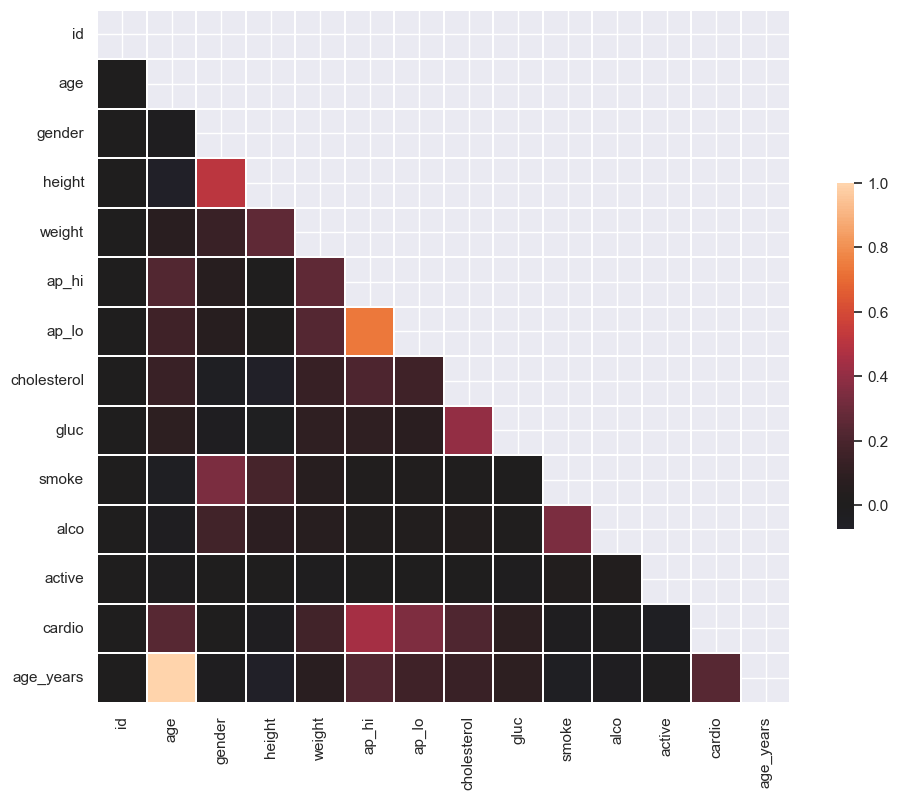

In [331]:
df.corr(method='pearson')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=False, square=True, linewidths=.1, cbar_kws={"shrink": .5})

### Вопрос 2.1 Какая пара признаков имеет наиболее сильную корреляцию Пирсона с гендерным признаком?

#### Ответ: Рост и курение.

### 2.2 Распределение мужчин и женщин по росту. Создайте violin-график для роста и пола, используя violinplot().

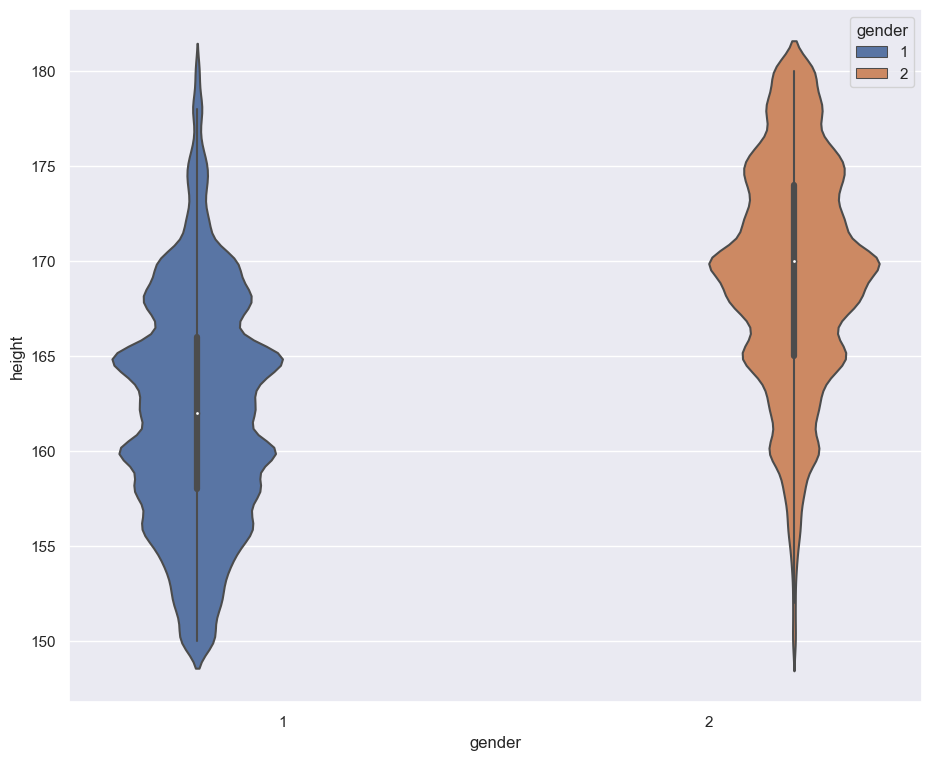

In [313]:
sns.violinplot(x='gender', y='height', hue ='gender', data=df, density_norm='count' );

### 2.3. Ранговая корреляция. Рассчитайте и постройте матрицу корреляции, используя коэффициент ранговой корреляции Спирмена.

<Axes: >

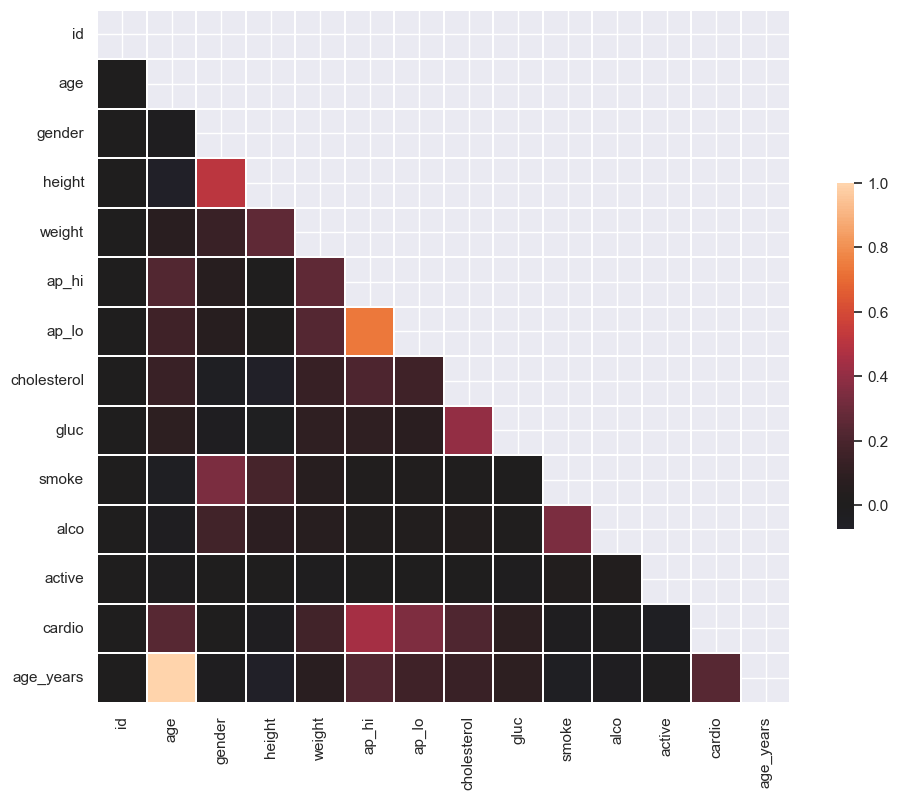

In [333]:
corr = df.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=False, square=True, linewidths=.1, cbar_kws={"shrink": .5})

### Вопрос 2.2. Какая пара признаков имеет самую сильную ранговую корреляцию Спирмена?

#### Ответ: ap_hi, ap_lo (верхнее и нижнее арт. давление)

### Вопрос 2.3.  Почему эти признаки имеют сильную ранговую корреляцию?

#### Ответ: Характер данных.

### 2.4. Возраст. Создайте график подсчета , используя countplot()возраст по оси X и количество людей по оси Y. Полученный график должен содержать два столбца для каждого возраста, что соответствует количеству людей в каждом кардио-классе этого возраста.

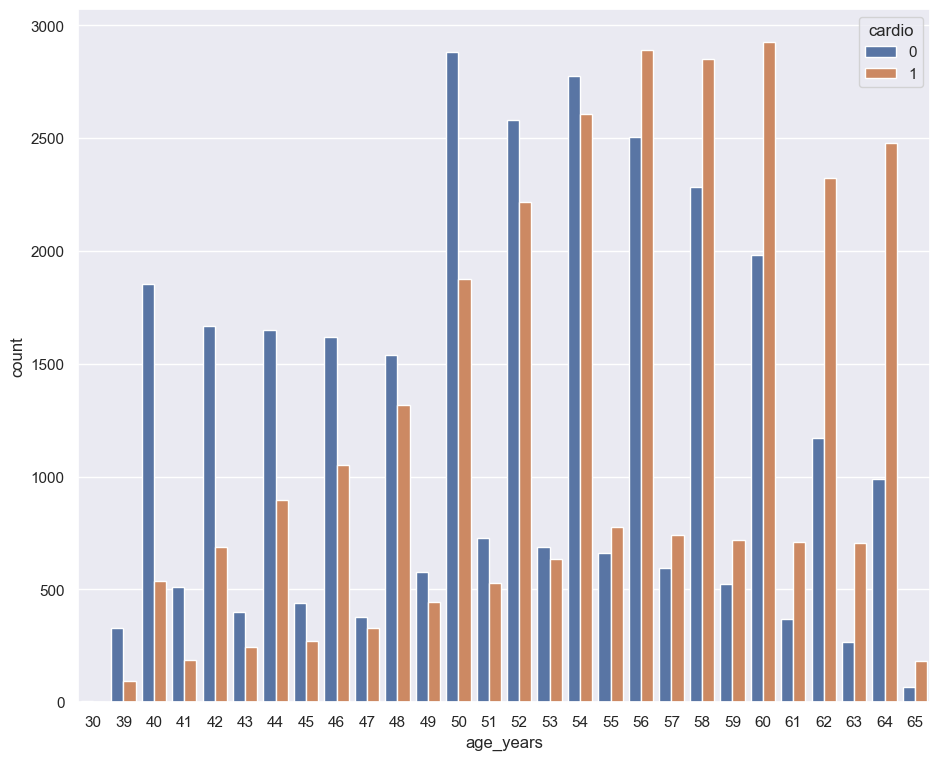

In [361]:
df['cardio'] = df['cardio'].astype(str)
sns.countplot(x="age_years", hue="cardio", data=df);

### Вопрос 2.4. Каков минимальный возраст, в котором число людей с ССЗ превышает количество людей без ССЗ?




#### Ответ: 55 лет.

In [3]:
from math import log


def entropy(a_list):
    lst = list(a_list)
    size = len(lst)
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0, 1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ / size * log(occ / size, 2)
    return entropy

In [7]:
balls = [1 for i in range(9)] + [0 for i in range(11)]
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow




print(entropy(balls))  # 9 blue and 11 yellow ones
print(entropy(balls_left))  # 8 blue and 5 yellow ones
print(entropy(balls_right))  # 1 blue and 6 yellow ones
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156
